# CIFAR examples

This code runs CIFAR10 and CIFAR100. To switch between these two datasets, update the `dataset` field in `train_config.yaml` and the `data_path` field in `audit.yaml` accordingly.


In [1]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)


In [8]:
from utils.cifar_model_preparation import ResNet18, create_trained_model_and_metadata

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [3]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

root = train_config["data"]["data_dir"]
# Load the CIFAR train and test datasets
if train_config["data"]["dataset"] == "cifar10":
    trainset = CIFAR10(root=root, train=True, download=True)
    testset = CIFAR10(root=root, train=False, download=True)
elif train_config["data"]["dataset"] == "cifar100":
    trainset = CIFAR100(root=root, train=True, download=True)
    testset = CIFAR100(root=root, train=False, download=True)
else:
    raise ValueError("Unknown dataset type")

train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255

# Ensure train and test data looks correct
assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
assert train_data.shape[1] == 3, "Data should have 3 channels"
assert test_data.shape[1] == 3, "Data should have 3 channels"
assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"

# Concatenate train and test data into the population
data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
# Create UserDataset object
population_dataset = CifarInputHandler.UserDataset(data, targets)

assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"

# Store the population dataset to be used by LeakPro
dataset_name = train_config["data"]["dataset"]
file_path =  "data/"+ dataset_name + ".pkl"
if not os.path.exists(file_path):
    with open(file_path, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {file_path}")

With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size)
test_size = int(test_fraction * dataset_size)

selected_index = np.random.choice(np.arange(dataset_size), train_size + test_size, replace=False)
train_indices, test_indices = train_test_split(selected_index, test_size=test_size)

train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)

With the train and test dataloader in place, start training the target model.

In [9]:
# Train the model
if not os.path.exists("target"):
    os.makedirs("target")
if train_config["data"]["dataset"] == "cifar10":
    num_classes = 10
elif train_config["data"]["dataset"] == "cifar100":
    num_classes = 100
else:
    raise ValueError("Invalid dataset name")

model = ResNet18(num_classes = num_classes)

# train target model
print(f"Training on {len(train_loader.dataset)} samples")
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model, 
                                                                               train_loader, 
                                                                               test_loader, 
                                                                               train_config, 
                                                                               train_indices,
                                                                               test_indices)

Training on 24000 samples


Epoch 3/3: 100%|██████████| 188/188 [00:02<00:00, 90.25it/s]


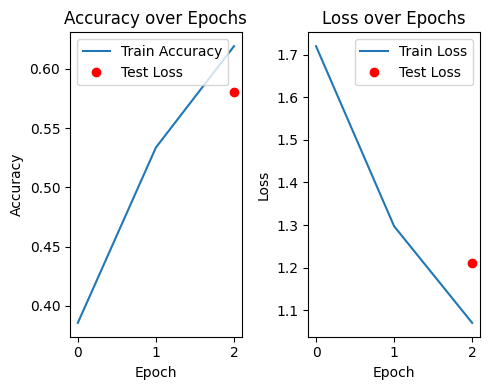

In [10]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from cifar_handler import CifarInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(CifarInputHandler, config_path)

# Run the audit 
leakpro.run_audit()

2025-03-17 21:24:50,455 INFO     Target model blueprint created from ResNet18 in ./utils/cifar_model_preparation.py.
2025-03-17 21:24:50,469 INFO     Loaded target model metadata from ./target/model_metadata.pkl
2025-03-17 21:24:50,664 INFO     Loaded target model from ./target
2025-03-17 21:24:51,540 INFO     Loaded population dataset from ./data/cifar10.pkl
2025-03-17 21:24:51,541 INFO     Loaded population dataset from ./data/cifar10.pkl
2025-03-17 21:24:51,542 INFO     Image extension initialized.
2025-03-17 21:24:51,564 INFO     MIA attack factory loaded.
2025-03-17 21:24:51,565 INFO     Creating shadow model handler singleton
2025-03-17 21:24:51,613 INFO     Creating distillation model handler singleton
2025-03-17 21:24:51,646 INFO     Added attack: lira
2025-03-17 21:24:51,646 INFO     Preparing attack: lira
2025-03-17 21:24:52,087 INFO     Training shadow model 20 on 24064 points
Epoch 3/3: 100%|██████████| 188/188 [00:02<00:00, 90.15it/s]
2025-03-17 21:24:59,927 INFO     Train

KeyboardInterrupt: 

Text(0.5, 1.0, 'Test')

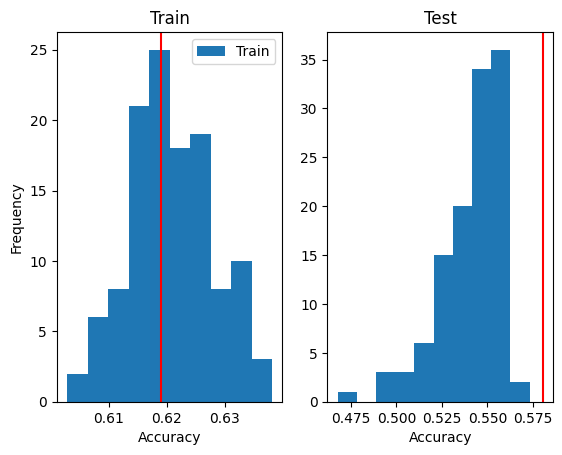

In [11]:
# Read from /leakpro_output/attack_objects/shadow_model and load all meatdata
import pickle
import os

shadow_model_path = os.path.join(os.getcwd(), "leakpro_output/attack_objects/shadow_model")
shadow_train_acc = []
shadow_test_acc = []
for file in os.listdir(shadow_model_path):
    if "metadata" not in file.lower():  # Ensure only files containing "metadata" are processed
        continue  

    with open(os.path.join(shadow_model_path, file), 'rb') as f:
        tmp_file = pickle.load(f, fix_imports=True)
        shadow_train_acc.append(tmp_file.train_acc)
        shadow_test_acc.append(tmp_file.test_acc)

# Plot the train and test accuracy of the shadow models as histograms
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.subplot(1, 2, 1)
plt.hist(shadow_train_acc, label='Train')
# add the train_acc (single point) as a vertical line
plt.axvline(x=train_acc[-1], color='r')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Train')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(shadow_test_acc, label='Test')
plt.axvline(x=test_acc, color='r')
plt.xlabel('Accuracy')
plt.title('Test')